# Analyze Region 8 - Scandinavia

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 8 - Scandinavia.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "8"
region_name = "Scandinavia"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 4 # This was not already set in GLIMS so this is Michael's suggestion

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 7
region_index_2 = 8

# Ice cap/icefield epsg code used for calculating area
ic_epsg = '3049'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 0

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

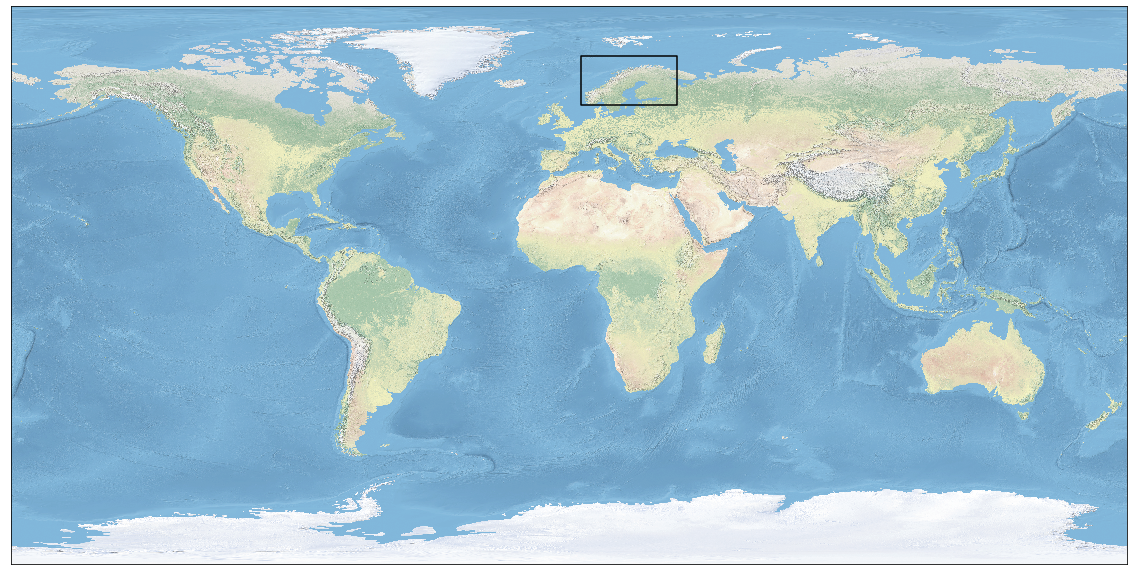

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

minx  miny  maxx  maxy
7   4.0  58.0  35.0  74.0

# * * * * * * * * Glacier Analysis * * * * * * * *

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

region_no         glac_id  area  db_area  width  length  primeclass  \
0          8  G014136E66566N   0.0  55.4478    0.0     0.0         0.0   
1          8  G006998E61646N   0.0  47.4723    0.0     0.0         0.0   
2          8  G007099E61715N   0.0  41.8721    0.0     0.0         0.0   
3          8  G013994E66685N   0.0  41.2352    0.0     0.0         0.0   
4          8  G013853E66657N   0.0  36.0486    0.0     0.0         0.0   

   min_elev  mean_elev  max_elev             src_date           glac_name  \
0       0.0        0.0       0.0  1999-09-07T00:00:00      Austerdalsisen   
1       0.0        0.0       0.0  2006-09-16T00:00:00   Tunsbergdalsbreen   
2       0.0        0.0       0.0  2006-09-16T00:00:00        Nigardsbreen   
3       0.0        0.0       0.0  1999-09-07T00:00:00  Storglombreen nord   
4       0.0        0.0       0.0  1999-09-07T00:00:00           Engabreen   

                                            geometry  
0  POLYGON Z ((14.04475 66.581346 0, 14.044073 66...  
1  POLYGON Z ((7.022183 61.672159 0, 7.021715 61....  
2  POLYGON Z ((7.195026 61.718653 0, 7.193632 61....  
3  POLYGON Z ((14.017706 66.70696100000001 0, 14....  
4  POLYGON Z ((13.836885 66.686262 0, 13.836918 6...

## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

In [12]:
rgi_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate  CenLon  CenLat  \
0  RGI60-08.00281  G014136E66566N  19990907  -9999999  14.136  66.566   
1  RGI60-08.00434  G006998E61646N  20060916  -9999999   6.998  61.646   
2  RGI60-08.01126  G007099E61715N  20060916  -9999999   7.099  61.715   
3  RGI60-08.00287  G013994E66685N  19990907  -9999999  13.994  66.685   
4  RGI60-08.01657  G013853E66657N  19990907  -9999999  13.853  66.657   

  O1Region O2Region    Area  Zmin  ...  Aspect   Lmax  Status  Connect  Form  \
0        8        1  55.448   485  ...     176  12811       0        0     0   
1        8        2  47.472   648  ...     133  20867       0        0     0   
2        8        2  41.872   322  ...     117  13247       0        0     0   
3        8        1  41.235   570  ...      26   6109       0        0     0   
4        8        1  36.049   148  ...     330   9888       0        0     0   

   TermType  Surging  Linkages               Name  \
0         0        9         0     Austerdalsisen   
1         0        9         1  Tunsbergdalsbreen   
2         0        9         1       Nigardsbreen   
3         0        9         1    Storglombreen N   
4         0        9         1          Engabreen   

                                            geometry  
0  POLYGON ((14.04475000400004 66.58134600000005,...  
1  POLYGON ((7.022183000000041 61.67215900000008,...  
2  POLYGON ((7.195026000000041 61.71865300000007,...  
3  POLYGON ((14.01770600000003 66.70696100000004,...  
4  POLYGON ((13.83688500000005 66.68626200000006,...  

[5 rows x 23 columns]

## Plot GLIMS Glaciers

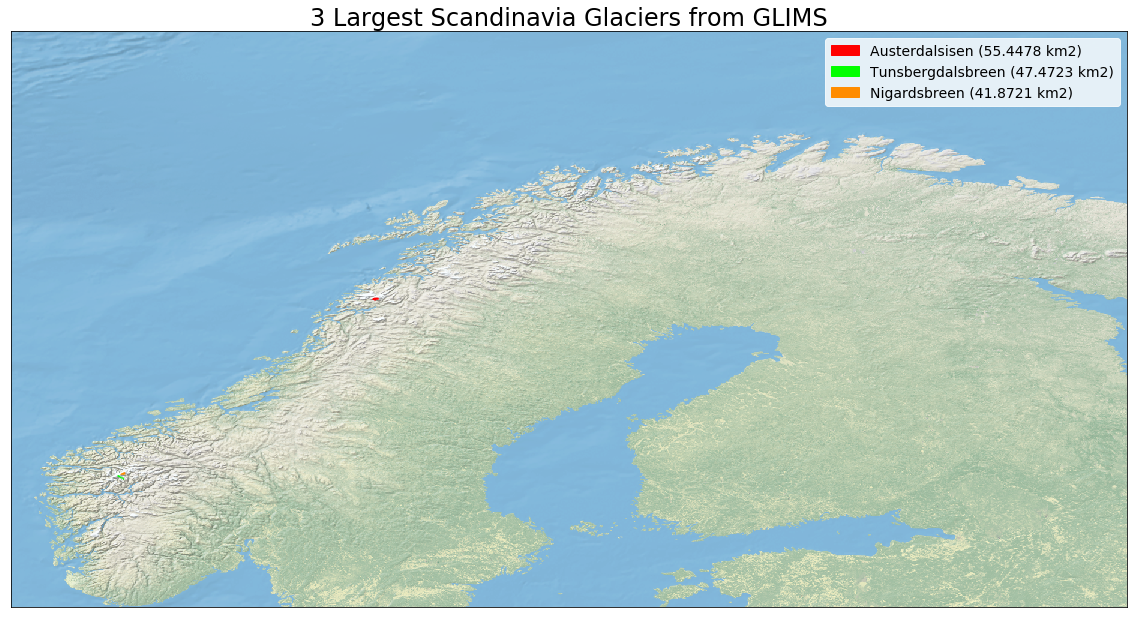

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

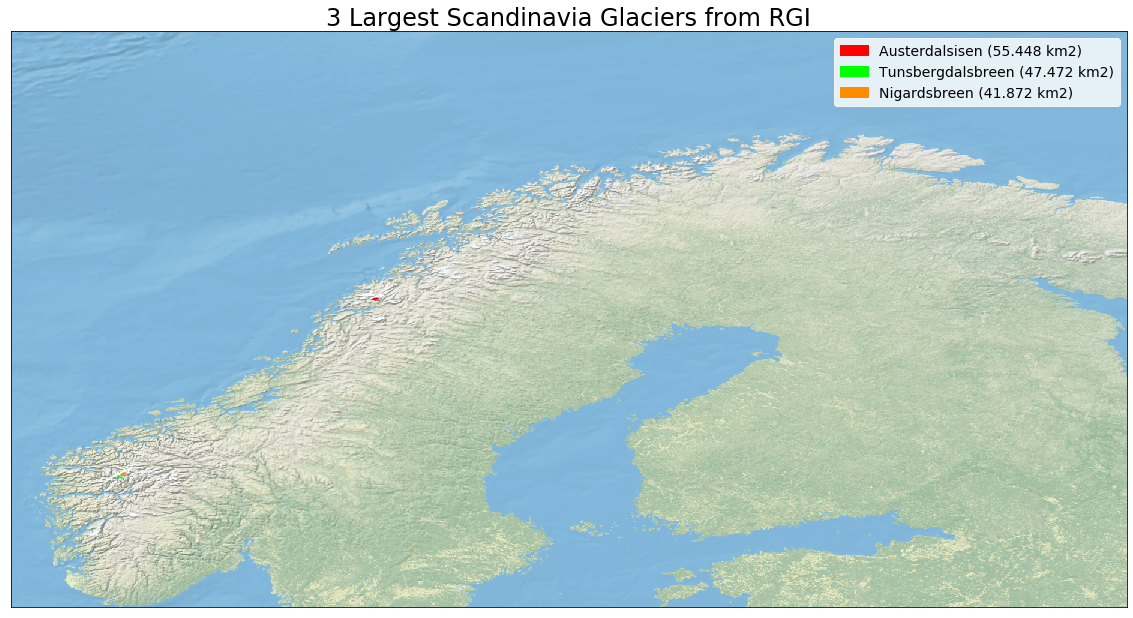

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They match!


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

### Create final glacier dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_glacier_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 'min_elev', 
                                                'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Update primary class (primeclass) column. 
final_glacier_data_df['primeclass'] = primeclass

# Rename some columns
final_glacier_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop last 2 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_glacier_data_df.drop([3, 4], inplace = True)

# Add RGI ID column
final_glacier_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][0], rgi_glaciers_df['RGIId'][1], 
                                   rgi_glaciers_df['RGIId'][2])

# Add area_src column that gets filled lower down
final_glacier_data_df['area_src'] = '-999'

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                               'primeclass', 'area_km2', 'area_src', 'date', 'geometry']]

In [17]:
final_glacier_data_df

region_no     reg_name          glac_name        glims_id          rgi_id  \
0          8  Scandinavia     Austerdalsisen  G014136E66566N  RGI60-08.00281   
1          8  Scandinavia  Tunsbergdalsbreen  G006998E61646N  RGI60-08.00434   
2          8  Scandinavia       Nigardsbreen  G007099E61715N  RGI60-08.01126   

   primeclass  area_km2 area_src                 date  \
0           4   55.4478     -999  1999-09-07T00:00:00   
1           4   47.4723     -999  2006-09-16T00:00:00   
2           4   41.8721     -999  2006-09-16T00:00:00   

                                            geometry  
0  POLYGON Z ((14.04475 66.581346 0, 14.044073 66...  
1  POLYGON Z ((7.022183 61.672159 0, 7.021715 61....  
2  POLYGON Z ((7.195026 61.718653 0, 7.193632 61....

In [18]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if glims_year == rgi_year:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
        area_src = 'A'
        print('Averaging area: ' + str(area))
    elif glims_year > rgi_year:
        # Use GLIMS area for the area
        area = glims_glaciers_df['db_area'][x]
        area_src = 'G'
        print('Using GLIMS area: ' + str(area))
    elif rgi_year > glims_year:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x]
        area_src = 'R'
        print('Using RGI area: ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_src')] = area_src
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]
    
    # Use the glacier names from RGI for the final data df
    if x == 0:
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = rgi_glaciers_df['Name'][x]
    if x == 1:
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = rgi_glaciers_df['Name'][x]
    if x == 2:
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = rgi_glaciers_df['Name'][x]

glims date: 19990907
rgi date: 19990907
Averaging area: 55.447900000000004

glims date: 20060916
rgi date: 20060916
Averaging area: 47.47215

glims date: 20060916
rgi date: 20060916
Averaging area: 41.87205



In [19]:
final_glacier_data_df

region_no     reg_name          glac_name        glims_id          rgi_id  \
0          8  Scandinavia     Austerdalsisen  G014136E66566N  RGI60-08.00281   
1          8  Scandinavia  Tunsbergdalsbreen  G006998E61646N  RGI60-08.00434   
2          8  Scandinavia       Nigardsbreen  G007099E61715N  RGI60-08.01126   

   primeclass  area_km2 area_src        date  \
0           4  55.44790        A  1999-09-07   
1           4  47.47215        A  2006-09-16   
2           4  41.87205        A  2006-09-16   

                                            geometry  
0  POLYGON Z ((14.04475 66.581346 0, 14.044073 66...  
1  POLYGON Z ((7.022183 61.672159 0, 7.021715 61....  
2  POLYGON Z ((7.195026 61.718653 0, 7.193632 61....

### Plot final glacier dataframe to check accuracy

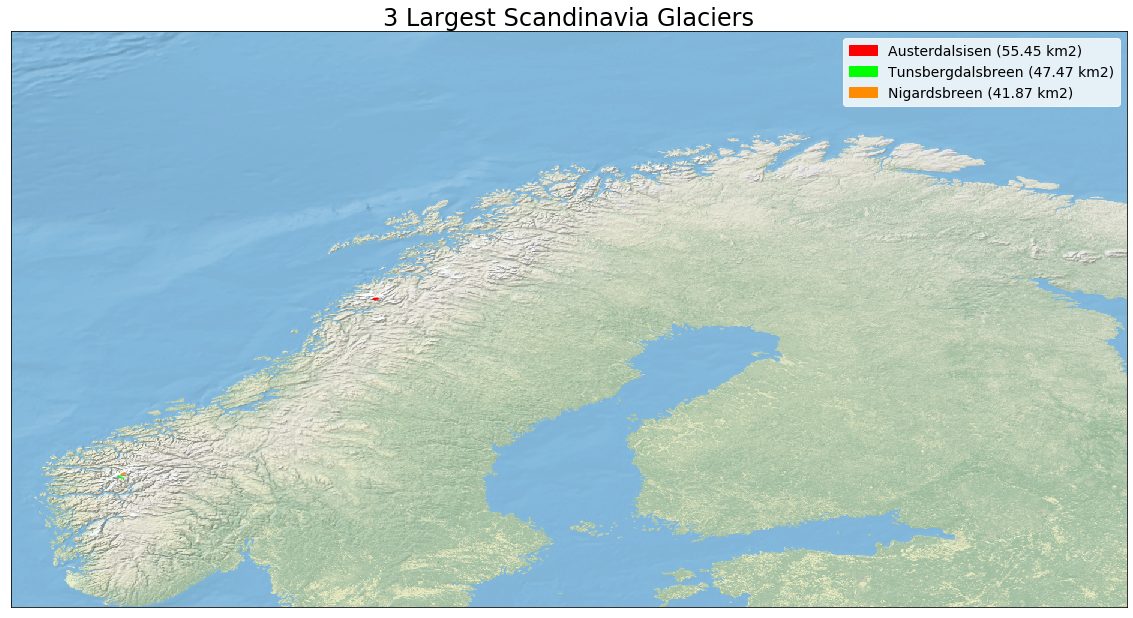

In [20]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [21]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-8-largest-glaciers.zip


# * * * * * * * * Ice Cap Analysis * * * * * * * *

Ice cap names from Inventory of Norwegian glaciers (Andreassen et al., 2012)

In [5]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                  region_number + "_epsg" + ic_epsg + ".shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [6]:
ice_caps_ex_df

id        area                                           geometry
0    16  533.132714  POLYGON ((6.8937 61.517777, 6.893516 61.517774...
1    34  225.507169  POLYGON ((13.838489 66.549521, 13.837876 66.54...
2     4  176.098646  POLYGON ((6.321743 59.938767, 6.321196 59.9387...
3    35  152.060041  POLYGON ((14.241743 66.556301, 14.24144 66.556...
4    37   89.423341  POLYGON ((16.14372 67.210577, 16.143718 67.210...
5   195   76.028362  POLYGON ((7.454642 60.504009, 7.4544 60.504006...
6    17   55.118128  POLYGON ((14.281602 65.963234, 14.281564 65.96...
7  1336   51.859755  POLYGON ((6.749329 61.688497, 6.749347 61.6882...
8    56   38.924697  POLYGON ((22.156415 70.15474399999999, 22.1562...
9  1904   37.589404  POLYGON ((16.39047126232961 67.13777414066014,...

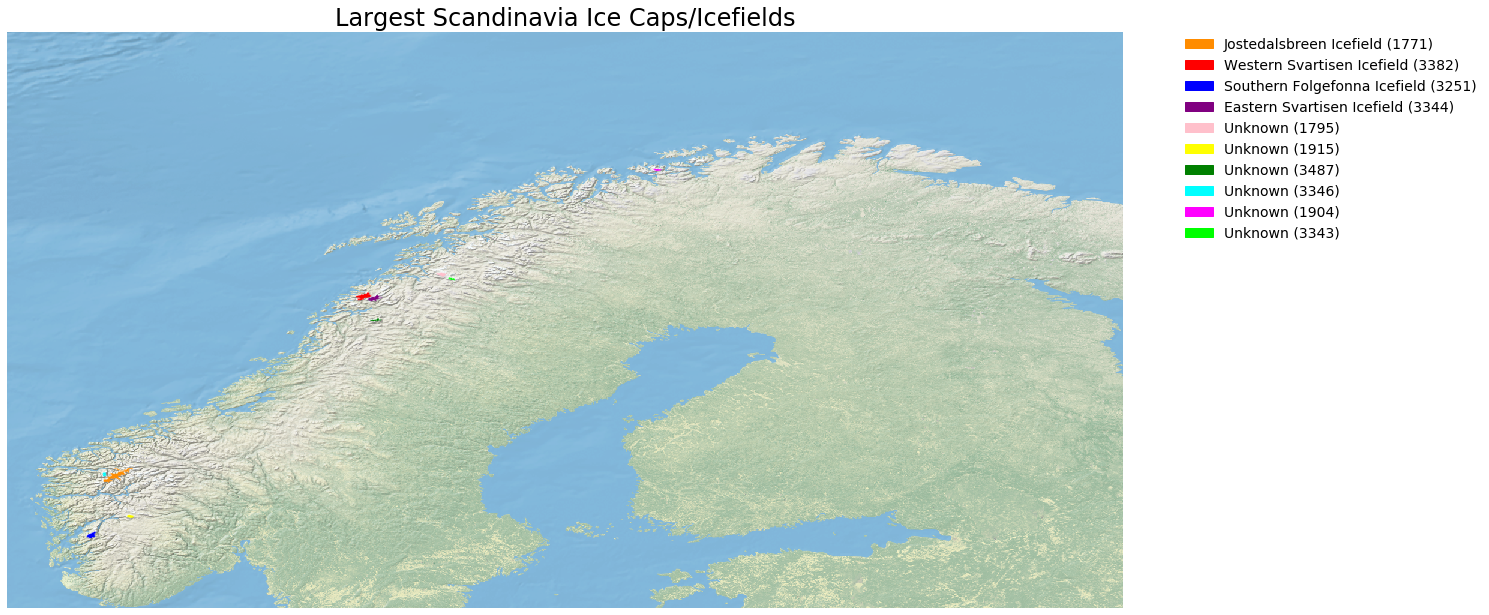

In [7]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Jostedalsbreen Icefield (1771)', 'Western Svartisen Icefield (3382)', 'Southern Folgefonna Icefield (3251)', 
                 'Eastern Svartisen Icefield (3344)', 'Unknown (1795)', 'Unknown (1915)', 'Unknown (3487)', 
                 'Unknown (3346)', 'Unknown (1904)', 'Unknown (3343)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [8]:
# Stop notebook and examine ice caps and icefields. 
# Comment this out when not needed.
#class StopExecution(Exception):
#    def _render_traceback_(self):
#        pass

#print("Stopping notebook to examine glacier complexes.")
#raise StopExecution

## Create Final Ice Catchment Data Frame
This ice catchment data frame will then be saved to a shapefile.

In [9]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps and icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [2, 2, 2]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Jostedalsbreen Icefield', 'Western Svartisen Icefield', 'Southern Folgefonna Icefield']

### Get ice catchment measurement dates from a range of glacier outline dates.

In [10]:
# Open GLIMS shapefile with all of the glacier outlines
glims_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [11]:
# Get glaciers on jostedals Ice Cap
jostedals_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True))
jostedals_glaciers = glims_all_glaciers_df.loc[jostedals_ic_mask]
jostedals_glaciers.reset_index(drop=True, inplace=True)

# Print the minimum date and the maximum date
jostedals_glaciers_min_date = jostedals_glaciers['src_date'].min()[0:10]
jostedals_glaciers_max_date = jostedals_glaciers['src_date'].max()[0:10]
print('jostedals start date: ' + jostedals_glaciers_min_date)
print('jostedals end date: ' + jostedals_glaciers_max_date)
print('')

# Get all glims ids that make up the jostdals ice catchment
jos_glims_ids = jostedals_glaciers['glac_id']
for i in range(len(jos_glims_ids)):
    if i == 0:
        all_jos_ids = jos_glims_ids[i]
    else:
        all_jos_ids = all_jos_ids + ', ' + jos_glims_ids[i]

# Get glaciers on Svartisen Ice Cap
svart_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
svart_glaciers = glims_all_glaciers_df.loc[svart_ic_mask]
svart_glaciers.reset_index(drop=True, inplace=True)

# Print the minimum date and the maximum date
svart_glaciers_min_date = svart_glaciers['src_date'].min()[0:10]
svart_glaciers_max_date = svart_glaciers['src_date'].max()[0:10]
print('svart start date: ' + svart_glaciers_min_date)
print('svart end date: ' + svart_glaciers_max_date)
print('')

# Get all glims ids that make up the svartisen ice catchment
sva_glims_ids = svart_glaciers['glac_id']
for i in range(len(sva_glims_ids)):
    if i == 0:
        all_sva_ids = sva_glims_ids[i]
    else:
        all_sva_ids = all_sva_ids + ', ' + sva_glims_ids[i]

# Get glaciers on Folgefonni Ice Cap
folge_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True))
folge_glaciers = glims_all_glaciers_df.loc[folge_ic_mask]
folge_glaciers.reset_index(drop=True, inplace=True)

# Print the minimum date and the maximum date
folge_glaciers_min_date = folge_glaciers['src_date'].min()[0:10]
folge_glaciers_max_date = folge_glaciers['src_date'].max()[0:10]
print('folge start date: ' + folge_glaciers_min_date)
print('folge end date: ' + folge_glaciers_max_date)
print('')

# Get all glims ids that make up the folgefoinni ice catchment
fol_glims_ids = folge_glaciers['glac_id']
for i in range(len(fol_glims_ids)):
    if i == 0:
        all_fol_ids = fol_glims_ids[i]
    else:
        all_fol_ids = all_fol_ids + ', ' + fol_glims_ids[i]

jostedals start date: 2006-09-16
jostedals end date: 2006-09-16

svart start date: 1999-09-07
svart end date: 1999-09-07

folge start date: 2002-09-13
folge end date: 2002-09-13



In [12]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [jostedals_glaciers_min_date, svart_glaciers_min_date, folge_glaciers_min_date]

final_catchment_data_df['max_date'] = [jostedals_glaciers_max_date, svart_glaciers_max_date, folge_glaciers_max_date]

# Add the GLIMS IDS
final_catchment_data_df['glims_ids'] = [all_jos_ids, all_sva_ids, all_fol_ids]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 
                                                   'min_date', 'max_date', 'glims_ids', 'geometry']]
# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [13]:
final_catchment_data_df

region_no     reg_name                       ic_name  primeclass  \
0         8  Scandinavia       Jostedalsbreen Icefield           2   
1         8  Scandinavia    Western Svartisen Icefield           2   
2         8  Scandinavia  Southern Folgefonna Icefield           2   

     area_km2    min_date    max_date  \
0  533.132714  2006-09-16  2006-09-16   
1  225.507169  1999-09-07  1999-09-07   
2  176.098646  2002-09-13  2002-09-13   

                                           glims_ids  \
0  G006998E61646N, G006712E61508N, G006785E61632N...   
1  G014011E66745N, G013784E66582N, G013736E66590N...   
2  G006261E60022N, G006363E60053N, G006284E60028N...   

                                            geometry  
0  POLYGON ((6.8937 61.517777, 6.893516 61.517774...  
1  POLYGON ((13.838489 66.549521, 13.837876 66.54...  
2  POLYGON ((6.321743 59.938767, 6.321196 59.9387...

### Plot the final catchment dataframe to verify it looks correct

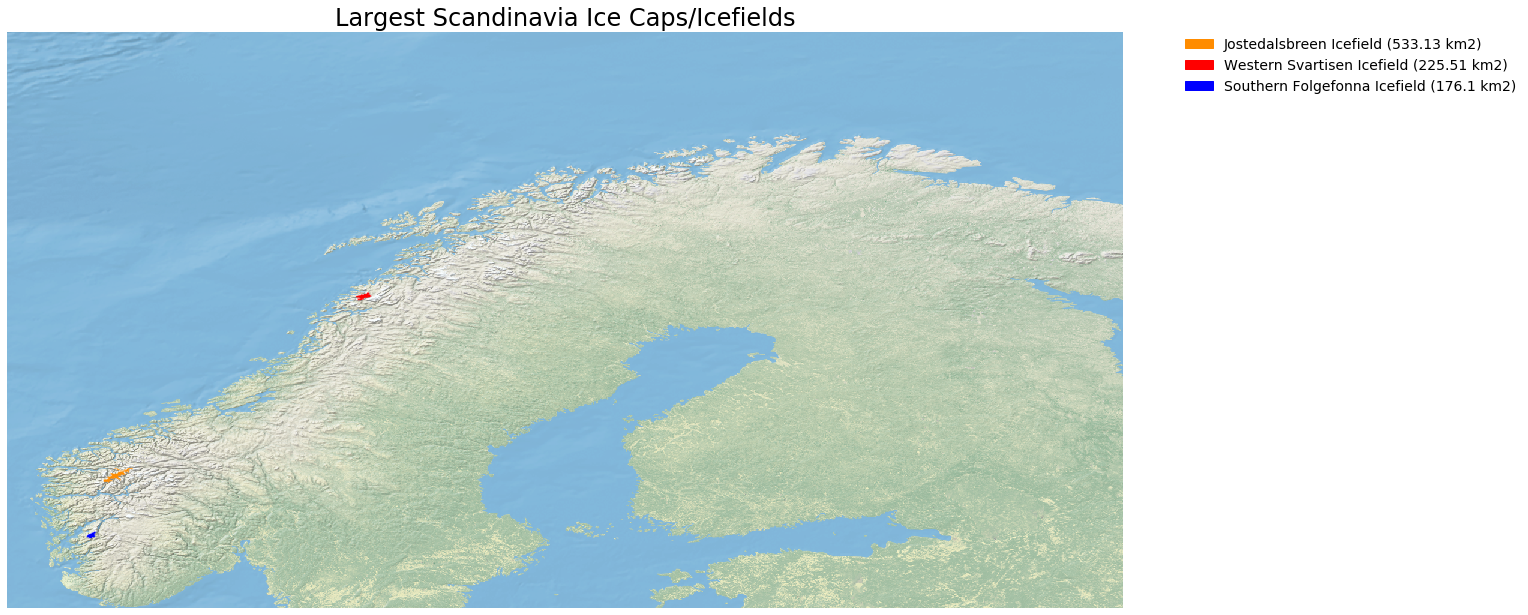

In [14]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="darkorange")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="red")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="blue")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [16]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-8-largest-complexes.zip
